In [24]:
# Code in file autograd/two_layer_net_autograd.py
import torch
from torch import nn as nn

device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [4]:
import numpy as np

In [5]:
N = 5 # input dimension and number of training behaviors
M = N # output dimension
R = 4 # hidden dimension

f_threshold = 0.4 # threshold for nonlinear binary rounding 
comb_on = M/2 # number of motors turned on for each label
learning_rate = 1e-3

In [6]:
# Define nonlinear activation function
def f(x): # nonlinear conversion function to binary
    return x.add(-f_threshold).tanh().add(1).div(2)

In [96]:
# Define nonlinear activation function
def loss_KL(y, y_pred): # nonlinear conversion function to binary
    r = nn.Softmax(dim=1)
    p = r(y_pred)
    q = y
    print(q)
    cross_H = -((1-p).add(-q*(1-2*p)).log()).sum(dim=1)
    # pure_H = -q*(q.log()).sum(dim=1)
    return nn.CrossEntropyLoss(q)

In [97]:
loss_KL(y, y)

tensor([[0., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0.]])


CrossEntropyLoss()

In [7]:
# Create input data
x_np = np.array([[1 if i ==j else 0 for i in range(N)] for j in range(N)])
x = torch.tensor(x_np, device=device).float()
print(x)

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]])


In [16]:
# Create output data
def y_seq_ones():
    return np.random.choice(np.arange(N), size= int(N/2), replace = False)
y_ones_all = [y_seq_ones() for i in range(N)]
y_np = np.array([[1 if i in y_ones_all[j] else 0 for i in range(N)] for j in range(N)])
y = torch.tensor(y_np, device=device).float()
print(y)

tensor([[0., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1.],
        [1., 0., 0., 1., 0.]])


In [195]:
# Create random Tensors for weights; setting requires_grad=True means that we
# want to compute gradients for these Tensors during the backward pass.
w1 = torch.randn(N, R, device=device, requires_grad=True).float()
w2 = torch.randn(R, M, device=device, requires_grad=True).float()

In [201]:
for t in range(10000):
  # Forward pass: compute predicted y using operations on Tensors. Since w1 and
  # w2 have requires_grad=True, operations involving these Tensors will cause
  # PyTorch to build a computational graph, allowing automatic computation of
  # gradients. Since we are no longer implementing the backward pass by hand we
  # don't need to keep references to intermediate values.
  y_pred = f(f(x.mm(w1)).mm(w2))
  
  # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
  # is a Python number giving its value.
  loss = (y_pred - y).pow(2).sum()
  print(t, loss.item())

  # Use autograd to compute the backward pass. This call will compute the
  # gradient of loss with respect to all Tensors with requires_grad=True.
  # After this call w1.grad and w2.grad will be Tensors holding the gradient
  # of the loss with respect to w1 and w2 respectively.
  loss.backward()

  # Update weights using gradient descent. For this step we just want to mutate
  # the values of w1 and w2 in-place; we don't want to build up a computational
  # graph for the update steps, so we use the torch.no_grad() context manager
  # to prevent PyTorch from building a computational graph for the updates
  with torch.no_grad():
    w1 -= learning_rate * w1.grad
    w2 -= learning_rate * w2.grad

    # Manually zero the gradients after running the backward pass
    w1.grad.zero_()
    w2.grad.zero_()

0 0.1250275820493698
1 0.12501491606235504
2 0.12500226497650146
3 0.12498964369297028
4 0.12497691065073013
5 0.12496428191661835
6 0.12495163083076477
7 0.12493900954723358
8 0.12492631375789642
9 0.12491370737552643
10 0.12490104883909225
11 0.12488837540149689
12 0.12487576901912689
13 0.1248631551861763
14 0.12485048919916153
15 0.12483785301446915
16 0.12482523918151855
17 0.12481261044740677
18 0.12479997426271439
19 0.12478736788034439
20 0.12477473169565201
21 0.12476208806037903
22 0.12474948167800903
23 0.12473688274621964
24 0.12472429871559143
25 0.12471165508031845
26 0.12469907104969025
27 0.12468645721673965
28 0.12467385083436966
29 0.12466124445199966
30 0.12464863806962967
31 0.12463606894016266
32 0.12462346255779266
33 0.12461089342832565
34 0.12459827959537506
35 0.12458566576242447
36 0.12457306683063507
37 0.12456052750349045
38 0.12454791367053986
39 0.12453534454107285
40 0.12452275305986404
41 0.12451018393039703
42 0.12449761480093002
43 0.12448500096797943


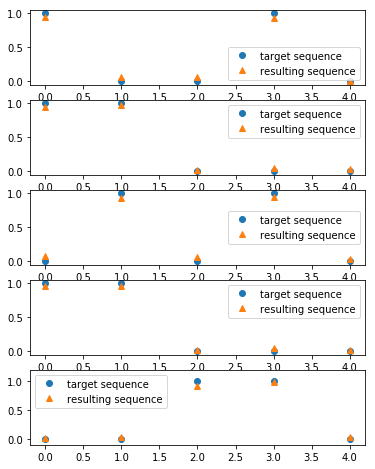

In [211]:
import matplotlib
from matplotlib import pyplot as plt

fig, ax = plt.subplots(N, 1)
fig.set_figheight(8)
for i in range(N):
    ax[i].plot(y_np[i], 'o', label = 'target sequence')
    ax[i].plot(y_pred[i].detach().numpy(), '^', label = 'resulting sequence')
    ax[i].legend()
    plt.ylim([-0.1, 1.2])

plt.show()